In [1]:
# load libraries
%matplotlib inline
from utils import *
import nltk
from nltk.corpus import stopwords
from time import time

Using Theano backend.


In [2]:
# import data
path = './'
ul_train = pd.read_csv(path+'unlabeledTrainData.tsv', sep='\t', header=0, quoting=3)
train = pd.read_csv(path+'labeledTrainData.tsv', sep='\t')
test = pd.read_csv(path+'testData.tsv', sep='\t')

In [3]:
ul_train.shape, train.shape, test.shape

((50000, 2), (25000, 3), (25000, 2))

In [4]:
from sys import getsizeof
getsizeof(ul_train)/float(2**20), getsizeof(train)/float(2**20), getsizeof(test)/float(2**20)

(68.3608865737915, 34.14770317077637, 33.21155548095703)

In [5]:
# see the content in 'train'
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


In [6]:
print train['review'][1]

\The Classic War of the Worlds\" by Timothy Hines is a very entertaining film that obviously goes to great effort and lengths to faithfully recreate H. G. Wells' classic book. Mr. Hines succeeds in doing so. I, and those who watched his film with me, appreciated the fact that it was not the standard, predictable Hollywood fare that comes out every year, e.g. the Spielberg version with Tom Cruise that had only the slightest resemblance to the book. Obviously, everyone looks for different things in a movie. Those who envision themselves as amateur \"critics\" look only to criticize everything they can. Others rate a movie on more important bases,like being entertained, which is why most people never agree with the \"critics\". We enjoyed the effort Mr. Hines put into being faithful to H.G. Wells' classic novel, and we found it to be very entertaining. This made it easy to overlook what the \"critics\" perceive to be its shortcomings."


In [7]:
# Text cleaning helper function
def clean_text(raw, remove_stopwords=False):
    # remove punctuation and symbols
    cleanedText = re.sub(r'[^\w\s\']+', '', raw)
    # change words to lowercase and split them
    words = cleanedText.lower().split()
    # remove stopwords
    if remove_stopwords:
        stops = set(stopwords.words('english'))
        words = [w for w in words if not w in stops]
    return words

In [8]:
# Cleaning and parsing texts
print "Cleaning the review texts..."
t0 = time()
train['review'] = train['review'].apply(clean_text)
ul_train['review'] = ul_train['review'].apply(clean_text)
test['review'] = test['review'].apply(clean_text)
print "Elapsed time %.2f seconds for cleaning\n" % (time()-t0)  # about 8 minutes

Cleaning the review texts...
Elapsed time 12.81 seconds for cleaning



In [9]:
getsizeof(ul_train)/float(2**20), getsizeof(train)/float(2**20), getsizeof(test)/float(2**20)

(100.46725654602051, 50.221282958984375, 48.97425365447998)

### Basic observation

In [10]:
' '.join(train['review'][1])

"the classic war of the worlds by timothy hines is a very entertaining film that obviously goes to great effort and lengths to faithfully recreate h g wells' classic book mr hines succeeds in doing so i and those who watched his film with me appreciated the fact that it was not the standard predictable hollywood fare that comes out every year eg the spielberg version with tom cruise that had only the slightest resemblance to the book obviously everyone looks for different things in a movie those who envision themselves as amateur critics look only to criticize everything they can others rate a movie on more important baseslike being entertained which is why most people never agree with the critics we enjoyed the effort mr hines put into being faithful to hg wells' classic novel and we found it to be very entertaining this made it easy to overlook what the critics perceive to be its shortcomings"

In [11]:
nb_rev, seq_len_per_rev = range(train.shape[0]), train['review'].apply(len)

In [12]:
# see the stats of 'sequence length each review' of train data
seq_len_per_rev.describe()

count    25000.000000
mean       232.805680
std        172.957383
min         10.000000
25%        127.000000
50%        174.000000
75%        283.000000
max       2469.000000
Name: review, dtype: float64

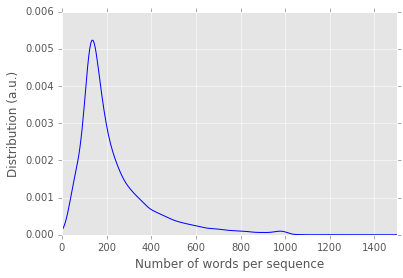

In [13]:
# see the distribution of sequence length
plt.style.use('ggplot')
seq_len_per_rev.plot.density(color='blue')
plt.xlim(0, 1500)
plt.xlabel('Number of words per sequence')
plt.ylabel('Distribution (a.u.)')
plt.show()

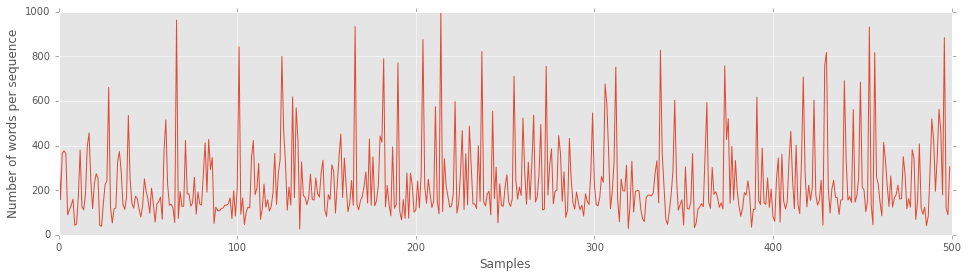

In [14]:
# see the lengths of sequence in a range
plt.figure(figsize=(16,4))
plt.plot(nb_rev[:500], seq_len_per_rev[:500])
plt.xlim(0, 500)
plt.xlabel('Samples')
plt.ylabel('Number of words per sequence')
plt.show()

In [15]:
# number of words in cleaned train set
word_freq = nltk.FreqDist(itertools.chain(*train['review']))
len(word_freq)

129596

In [16]:
# test set included
word_freq = nltk.FreqDist(itertools.chain(
    *pd.concat([train['review'], test['review']], ignore_index=True) ))
len(word_freq)

195312

In [17]:
# unlabeled test set included
word_freq = nltk.FreqDist(itertools.chain(
    *pd.concat([train['review'], ul_train['review'], test['review']], ignore_index=True) ))
len(word_freq)

303765

In [18]:
# Tokenize the review sentences as input; 'UNK' means the words not included
vocab_size = 50000
vocab_freq = word_freq.most_common(vocab_size-1)
idx_to_word = ['PAD'] + [w[0] for w in vocab_freq] + ['UNK']
word_to_idx = {w: i for i, w in enumerate(idx_to_word)}

In [19]:
word_to_idx['UNK']

50000

In [20]:
idx_to_word[:10]

['PAD', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i']

In [21]:
idx_to_word[-10:]

['scrolled',
 'jamia',
 "'child's",
 "snipes's",
 'zazu',
 "abbott's",
 'segmented',
 'triers',
 'shanghainese',
 'UNK']

In [22]:
word_freq['segmented'], word_freq['triers'], word_freq['shanghainese']

(8, 8, 8)

In [23]:
print "Tokenizing the review texts..."
t0 = time()
train['review'] = train['review'].apply(
    lambda x: np.array([word_to_idx[w] if w in word_to_idx else vocab_size for w in x]))
print "Elapsed time %.2f seconds for tokenizing\n" % (time()-t0)

Tokenizing the review texts...
Elapsed time 2.02 seconds for tokenizing



In [24]:
' '.join([idx_to_word[i] for i in train['review'][1]])

"the classic war of the worlds by timothy hines is a very entertaining film that obviously goes to great effort and lengths to faithfully recreate h g wells' classic book mr hines succeeds in doing so i and those who watched his film with me appreciated the fact that it was not the standard predictable hollywood fare that comes out every year eg the spielberg version with tom cruise that had only the slightest resemblance to the book obviously everyone looks for different things in a movie those who envision themselves as amateur critics look only to criticize everything they can others rate a movie on more important UNK being entertained which is why most people never agree with the critics we enjoyed the effort mr hines put into being faithful to hg wells' classic novel and we found it to be very entertaining this made it easy to overlook what the critics perceive to be its shortcomings"

In [26]:
# number of UNK
unk_per_rev = train['review'].apply(lambda x: len(np.where(x==vocab_size)[0]))

In [27]:
# see the stats of 'number of UNK each review' of train data
unk_per_rev.describe()

count    25000.000000
mean         4.366680
std          5.588634
min          0.000000
25%          1.000000
50%          3.000000
75%          6.000000
max         90.000000
Name: review, dtype: float64

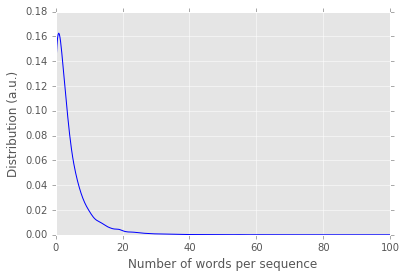

In [29]:
# see the distribution of number of UNK
plt.style.use('ggplot')
unk_per_rev.plot.density(color='blue')
plt.xlim(0, 100)
plt.xlabel('Number of words per sequence')
plt.ylabel('Distribution (a.u.)')
plt.show()

### Word vector observation

In [30]:
# import data
path = './'
ul_train = pd.read_csv(path+'unlabeledTrainData.tsv', sep='\t', header=0, quoting=3)
train = pd.read_csv(path+'labeledTrainData.tsv', sep='\t')
test = pd.read_csv(path+'testData.tsv', sep='\t')

In [31]:
# Cleaning and parsing texts
print "Tokenizing the review texts..."
t0 = time()
trn_sents = train['review'].apply(
	lambda x: [clean_text(s) for s in nltk.sent_tokenize(x.decode('utf-8'))])
ul_trn_sents = ul_train['review'].apply(
	lambda x: [clean_text(s) for s in nltk.sent_tokenize(x.decode('utf-8'))])
test_sents = test['review'].apply(
	lambda x: [clean_text(s) for s in nltk.sent_tokenize(x.decode('utf-8'))])

tokenized_sents = []
for rev in trn_sents:
	tokenized_sents += rev
for rev in ul_trn_sents:
	tokenized_sents += rev
for rev in test_sents:
	tokenized_sents += rev
print "Elapsed time %.2f seconds for tokenizing." % (time()-t0)

Tokenizing the review texts...
Elapsed time 89.08 seconds for tokenizing.


In [32]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

In [33]:
# Set values for various parameters
num_features = 50    # Word vector dimensionality                      
min_word_count = 30   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print "Training word vector model..."
model = word2vec.Word2Vec(tokenized_sents, workers=num_workers, \
            size=num_features, min_count=min_word_count, \
            window=context, sample=downsampling, sg=1)

2018-01-12 20:26:29,103 : INFO : 'pattern' package not found; tag filters are not available for English
2018-01-12 20:26:29,130 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2018-01-12 20:26:29,132 : INFO : collecting all words and their counts
2018-01-12 20:26:29,134 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-01-12 20:26:29,269 : INFO : PROGRESS: at sentence #10000, processed 221771 words, keeping 21558 word types


Training word vector model...


2018-01-12 20:26:29,394 : INFO : PROGRESS: at sentence #20000, processed 443869 words, keeping 31851 word types
2018-01-12 20:26:29,518 : INFO : PROGRESS: at sentence #30000, processed 659274 words, keeping 39544 word types
2018-01-12 20:26:29,624 : INFO : PROGRESS: at sentence #40000, processed 881317 words, keeping 46506 word types
2018-01-12 20:26:29,733 : INFO : PROGRESS: at sentence #50000, processed 1096616 words, keeping 52426 word types
2018-01-12 20:26:29,842 : INFO : PROGRESS: at sentence #60000, processed 1314377 words, keeping 57565 word types
2018-01-12 20:26:29,974 : INFO : PROGRESS: at sentence #70000, processed 1533443 words, keeping 62365 word types
2018-01-12 20:26:30,114 : INFO : PROGRESS: at sentence #80000, processed 1749199 words, keeping 66835 word types
2018-01-12 20:26:30,217 : INFO : PROGRESS: at sentence #90000, processed 1968941 words, keeping 71501 word types
2018-01-12 20:26:30,354 : INFO : PROGRESS: at sentence #100000, processed 2186467 words, keeping 75

2018-01-12 20:26:38,256 : INFO : PROGRESS: at sentence #740000, processed 16267059 words, keeping 243367 word types
2018-01-12 20:26:38,379 : INFO : PROGRESS: at sentence #750000, processed 16480914 words, keeping 245204 word types
2018-01-12 20:26:38,527 : INFO : PROGRESS: at sentence #760000, processed 16696510 words, keeping 247082 word types
2018-01-12 20:26:38,667 : INFO : PROGRESS: at sentence #770000, processed 16919304 words, keeping 249049 word types
2018-01-12 20:26:38,808 : INFO : PROGRESS: at sentence #780000, processed 17146255 words, keeping 251066 word types
2018-01-12 20:26:38,935 : INFO : PROGRESS: at sentence #790000, processed 17368837 words, keeping 253004 word types
2018-01-12 20:26:39,189 : INFO : PROGRESS: at sentence #800000, processed 17588146 words, keeping 255010 word types
2018-01-12 20:26:39,393 : INFO : PROGRESS: at sentence #810000, processed 17811586 words, keeping 257275 word types
2018-01-12 20:26:39,537 : INFO : PROGRESS: at sentence #820000, processe

2018-01-12 20:27:19,877 : INFO : PROGRESS: at 9.49% examples, 228451 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:27:20,880 : INFO : PROGRESS: at 9.80% examples, 229271 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:27:21,909 : INFO : PROGRESS: at 10.10% examples, 229883 words/s, in_qsize 8, out_qsize 1
2018-01-12 20:27:22,909 : INFO : PROGRESS: at 10.42% examples, 230823 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:27:23,929 : INFO : PROGRESS: at 10.75% examples, 231805 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:27:25,007 : INFO : PROGRESS: at 11.07% examples, 232382 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:27:26,040 : INFO : PROGRESS: at 11.40% examples, 233195 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:27:27,095 : INFO : PROGRESS: at 11.74% examples, 234012 words/s, in_qsize 7, out_qsize 0
2018-01-12 20:27:28,141 : INFO : PROGRESS: at 12.05% examples, 234329 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:27:29,149 : INFO : PROGRESS: at 12.37% examples, 235164 words

2018-01-12 20:28:41,986 : INFO : PROGRESS: at 32.82% examples, 234550 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:28:43,035 : INFO : PROGRESS: at 33.08% examples, 234285 words/s, in_qsize 7, out_qsize 0
2018-01-12 20:28:44,077 : INFO : PROGRESS: at 33.28% examples, 233685 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:28:45,108 : INFO : PROGRESS: at 33.52% examples, 233353 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:28:46,127 : INFO : PROGRESS: at 33.85% examples, 233646 words/s, in_qsize 7, out_qsize 0
2018-01-12 20:28:47,146 : INFO : PROGRESS: at 34.16% examples, 233817 words/s, in_qsize 7, out_qsize 0
2018-01-12 20:28:48,170 : INFO : PROGRESS: at 34.43% examples, 233675 words/s, in_qsize 7, out_qsize 0
2018-01-12 20:28:49,187 : INFO : PROGRESS: at 34.71% examples, 233688 words/s, in_qsize 7, out_qsize 0
2018-01-12 20:28:50,222 : INFO : PROGRESS: at 35.02% examples, 233858 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:28:51,264 : INFO : PROGRESS: at 35.34% examples, 234029 wor

2018-01-12 20:30:03,692 : INFO : PROGRESS: at 57.75% examples, 242686 words/s, in_qsize 6, out_qsize 1
2018-01-12 20:30:04,699 : INFO : PROGRESS: at 58.08% examples, 242823 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:30:05,710 : INFO : PROGRESS: at 58.41% examples, 242954 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:30:06,728 : INFO : PROGRESS: at 58.75% examples, 243115 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:30:07,729 : INFO : PROGRESS: at 59.08% examples, 243260 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:30:08,757 : INFO : PROGRESS: at 59.41% examples, 243372 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:30:09,761 : INFO : PROGRESS: at 59.73% examples, 243471 words/s, in_qsize 8, out_qsize 1
2018-01-12 20:30:10,772 : INFO : PROGRESS: at 60.06% examples, 243601 words/s, in_qsize 7, out_qsize 0
2018-01-12 20:30:11,782 : INFO : PROGRESS: at 60.38% examples, 243730 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:30:12,816 : INFO : PROGRESS: at 60.71% examples, 243833 wor

2018-01-12 20:31:25,224 : INFO : PROGRESS: at 83.63% examples, 248990 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:31:26,226 : INFO : PROGRESS: at 83.96% examples, 249072 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:31:27,265 : INFO : PROGRESS: at 84.29% examples, 249147 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:31:28,269 : INFO : PROGRESS: at 84.62% examples, 249228 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:31:29,285 : INFO : PROGRESS: at 84.97% examples, 249322 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:31:30,302 : INFO : PROGRESS: at 85.28% examples, 249365 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:31:31,314 : INFO : PROGRESS: at 85.59% examples, 249387 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:31:32,351 : INFO : PROGRESS: at 85.91% examples, 249413 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:31:33,377 : INFO : PROGRESS: at 86.22% examples, 249445 words/s, in_qsize 8, out_qsize 0
2018-01-12 20:31:34,419 : INFO : PROGRESS: at 86.54% examples, 249490 wor

In [35]:
# Using the trained model
print "The size of the trained word2vec model:", model.syn0.shape
print "Test finding the word doesn't match others:\n"
print "'%s' differs from other words in 'man woman child kitchen'" \
	% (model.doesnt_match("man woman child kitchen".split()))

print "The most similar words to 'man' is\n", model.most_similar("man")
print "Similarity between 'man' and 'woman':", model.similarity('man', 'woman')
print "\nThe most similar words to 'king' is\n", model.most_similar("king")
print "\nThe most similar words to 'awful' is\n", model.most_similar("awful")

print "Word embedding of 'computer' is", model['computer']

2018-01-12 20:38:15,188 : WARNING : direct access to syn0 will not be supported in future gensim releases, please use model.wv.syn0


The size of the trained word2vec model: (24312, 50)
Test finding the word doesn't match others:

'kitchen' differs from other words in 'man woman child kitchen'
The most similar words to 'man' is
[(u'woman', 0.771033763885498), (u'boy', 0.7640108466148376), (u'guy', 0.7600172162055969), (u'wheelchair', 0.7488577961921692), (u'lad', 0.7436563968658447), (u'beggar', 0.737058699131012), (u'chap', 0.7330985069274902), (u'soldier', 0.7324743866920471), (u"man's", 0.731645405292511), (u'tall', 0.7148261070251465)]
Similarity between 'man' and 'woman': 0.771033780221

The most similar words to 'king' is
[(u'prince', 0.8500112295150757), (u'kingdom', 0.8251842260360718), (u'lord', 0.8033628463745117), (u'mongol', 0.8015958666801453), (u'solomon', 0.7974182963371277), (u'throne', 0.7949026823043823), (u'camelot', 0.7870241403579712), (u'rudolf', 0.7733437418937683), (u'merlin', 0.768095076084137), (u'abbot', 0.7676976919174194)]

The most similar words to 'awful' is
[(u'terrible', 0.94683623313

In [36]:
print "Creating a index to word mapping..."
index2word = model.wv.index2word
word2index = {w:i for i, w in enumerate(index2word)}

Creating a index to word mapping...


In [38]:
num_points = 400
embeddings = np.zeros((num_points, num_features), dtype='float32')
for i in range(num_points):
    embeddings[i] = model[index2word[i]]

In [39]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(embeddings)

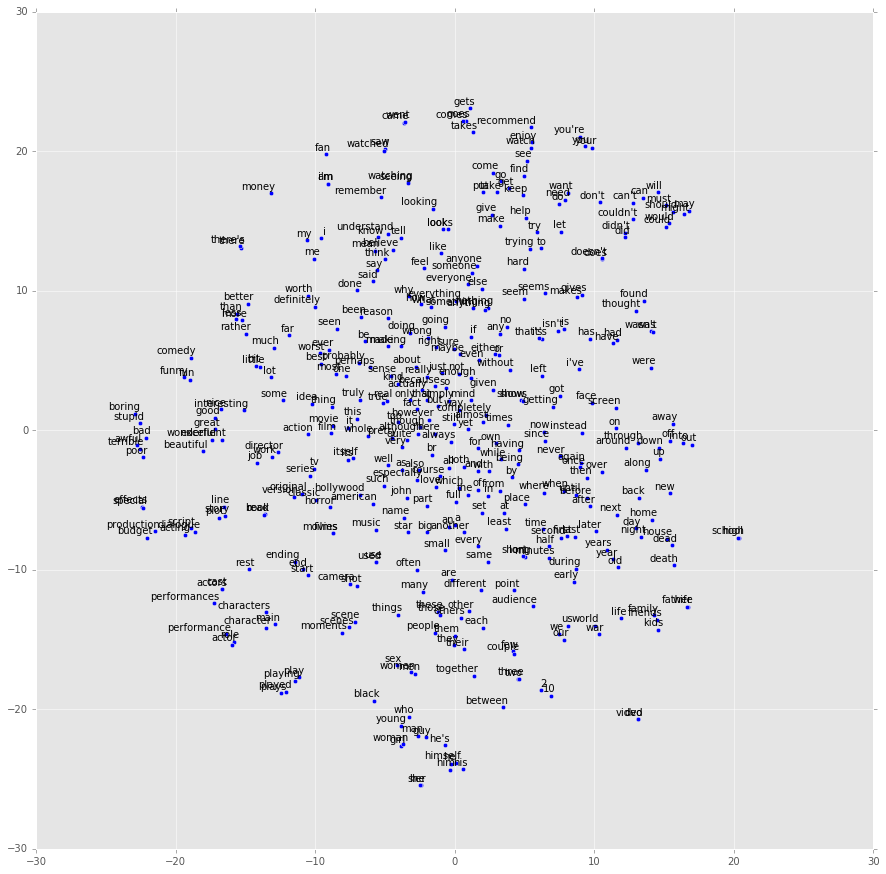

In [43]:
from matplotlib import pylab
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    pylab.style.use('ggplot')
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

plot(two_d_embeddings, index2word[:num_points])